# Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import sdf
import re
import glob
from tqdm import tqdm
from style import *
from tabulate import tabulate

plt.rcParams["font.size"] = 14
plt.rcParams["figure.figsize"] = (10, 8)

# Functions

In [2]:
SAVE_DIR = "images_2"

In [3]:
c = 299792458
PI = np.pi
pi = PI
m = 9.10938356e-31
e = 1.60217662e-19

lambd = 1e-6
f = c / lambd
omega = 2 * pi * f

In [4]:
def get_data(data_dir):
    DATA_DIR = data_dir
    ALL_FILES = glob.glob(f"{DATA_DIR}/*sdf")
    ALL_FILES.sort()
    POINTS = len(ALL_FILES)

    with open(os.path.join(DATA_DIR, "input.deck"), "r") as myfile:
        data = myfile.read()

    def find_value(info):
        regex = re.compile(rf"\s{info}\s*=\s*-?(\d+\.?\d*)")
        regex2 = re.compile(rf"\s*{info}\s*=\s*(.*)\n")
        match = regex.search(data)
        match2 = regex2.search(data)

        if match:
            return float(match.group(1))

        if match2:
            return float(eval(match2.group(1)))
        else:
            return None

    LAMBD = find_value("lambda0") * 1e-6
    LAS_TIME = int(find_value("las_time"))
    T_MAX = int(find_value("t_end"))
    DT = find_value("dt_snapshot") * 1e-15
    A0 = find_value("a0")
    FACTOR = int(find_value("factor"))
    NX = int(find_value("nx"))
    X_MIN = -int(find_value("x_min"))
    ANGLE = find_value("alpha")
    pol = find_value("polarisation")

    if pol is None:
        POL_TYPE = "p"
        POL_ANGLE = 0
    else:
        if float(pol) == 90.0:
            POL_ANGLE = 90
            POL_TYPE = "s"
        else:
            POL_ANGLE = float(pol)
            POL_TYPE = "p"

    beta = np.cos((ANGLE))
    tan_factor = np.tan((ANGLE))

    lambda_0 = LAMBD
    omega_0 = 2 * PI * c / lambda_0
    tau_0 = 2 * PI / omega_0

    lambda_m = LAMBD / beta
    omega_m = 2 * PI * c / lambda_m
    tau_m = 2 * PI / omega_m
    dt_m = DT
    dt_l = DT

    lambda_l = lambda_0
    omega_l = omega_0
    tau_l = tau_0

    LAS_TIME_L = LAS_TIME * tau_l
    LAS_TIME_M = LAS_TIME * tau_m
    T_MAX_L = T_MAX * tau_l
    T_MAX_M = T_MAX * tau_m

    ErM = (m * omega_m * c) / e
    ErL = (m * omega_l * c) / e

    L_frame_info = {
        "lambda": lambda_l,
        "tau": tau_l,
        "omega": omega_l,
        "laser_time": LAS_TIME_L,
        "t_end": T_MAX_L,
        "dt_dump": dt_l,
        "a0": A0,
        "factor": FACTOR,
        "nx": NX,
        "x_min_natural": X_MIN * lambda_l,
        "x_min": X_MIN,
    }

    M_frame_info = {
        "lambda": lambda_m,
        "tau": tau_m,
        "omega": omega_m,
        "laser_time": LAS_TIME_M,
        "t_end": T_MAX_M,
        "dt_dump": dt_m,
        "a0": A0,
        "factor": FACTOR,
        "nx": NX,
        "x_min_natural": X_MIN * lambda_m,
        "x_min": X_MIN,
    }

    def data_p():
        omega_max_m = 2 * np.pi / dt_m
        omegas = np.linspace(-omega_max_m / 2, omega_max_m / 2, POINTS)
        omegas_l = omegas / beta

        Ety = np.zeros(POINTS)
        Etx = np.zeros(POINTS)
        for i in tqdm(range(POINTS), "Loading Data..."):
            data = sdf.read(ALL_FILES[i])
            Ety[i] = data.Electric_Field_Ey.data[8000]
            Etx[i] = data.Electric_Field_Ex.data[8000]

        fft_x = np.fft.fftshift(np.fft.fft(Etx * tan_factor))
        fft_x = np.abs(fft_x) / (np.max(np.abs(fft_x))+1e-10)
        fft_y = np.fft.fftshift(np.fft.fft(Ety / ErL))
        fft_y = np.abs(fft_y) / (np.max(np.abs(fft_y))+1e-10)

        return omegas_l, fft_x, fft_y

    def data_s():
        omega_max_m = 2 * np.pi / dt_m
        omegas = np.linspace(-omega_max_m / 2, omega_max_m / 2, POINTS)
        omegas_l = omegas / beta

        Etz = np.zeros(POINTS)
        Etx = np.zeros(POINTS)
        for i in tqdm(range(POINTS), "Loading Data..."):
            data = sdf.read(ALL_FILES[i])
            Etz[i] = data.Electric_Field_Ez.data[8000]
            Etx[i] = data.Electric_Field_Ex.data[8000]

        fft_z = np.fft.fftshift(np.fft.fft(Etz / (ErL * beta)))
        fft_z = np.abs(fft_z) / (np.max(np.abs(fft_z))+1e-10)
        fft_x = np.fft.fftshift(np.fft.fft(Etx / ErL))
        fft_x = np.abs(fft_x) / (np.max(np.abs(fft_x))+1e-10)

        return omegas_l, fft_x, fft_z

    if POL_TYPE == "p":
        data = data_p()
    else:
        data = data_s()
    return data

In [5]:
dirs = glob.glob("*/*")
dirs = [x for x in dirs if "images" not in x]
dirs 

['p/0', 'p/12', 'p/3', 'p/4', 'p/6', 's/0', 's/12', 's/3', 's/4', 's/6']

In [6]:
dir_names = [dir.replace("/", "_") for dir in dirs]
dir_names

['p_0', 'p_12', 'p_3', 'p_4', 'p_6', 's_0', 's_12', 's_3', 's_4', 's_6']

In [7]:
data_dict = {}
for dir, dir_name in zip(dirs, dir_names):
    data_dict[dir_name] = get_data(dir)

Loading Data...: 100%|██████████| 2569/2569 [00:08<00:00, 316.12it/s]


In [8]:
def save_fig(ax, name):
    file_name = os.path.join(SAVE_DIR, name)
    ax.figure.savefig(file_name, dpi=300, bbox_inches="tight")

# Plots

## All Angles Together

/tmp/ipykernel_9495/3069048879.py:6: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax.set_yscale("log")


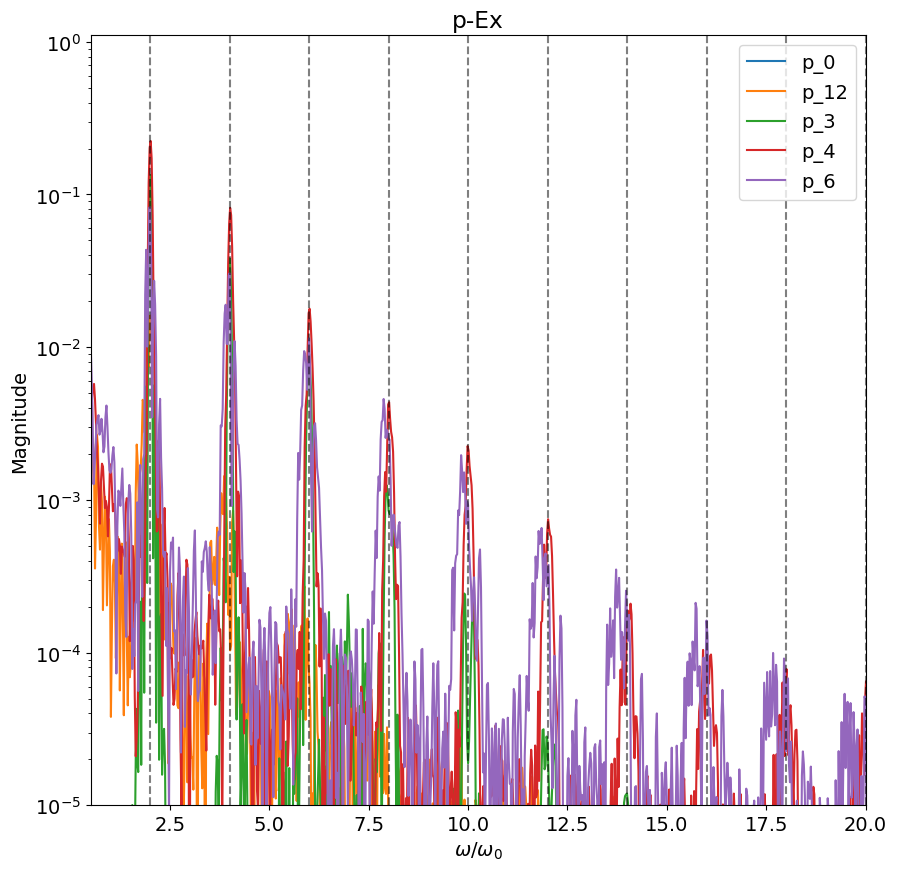

In [18]:
datas = ['p_0', 'p_12', 'p_3', 'p_4', 'p_6']
lines = np.arange(0, 21, 2)
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
for data in datas:
    ax.plot(data_dict[data][0]/omega, (data_dict[data][1])**2, label=data)
    ax.set_yscale("log")

for line in lines:
    ax.axvline(line, color="black", linestyle="--", alpha=0.5)
ax.legend()
ax.set_xlim(0.5, 20)
ax.set_ylim(1e-5, 1.1)
plt.xlabel(r"$\omega/\omega_0$")
plt.ylabel(r"Magnitude")
ax.set_title("p-Ex")
save_fig(ax, "p-Ex.png")

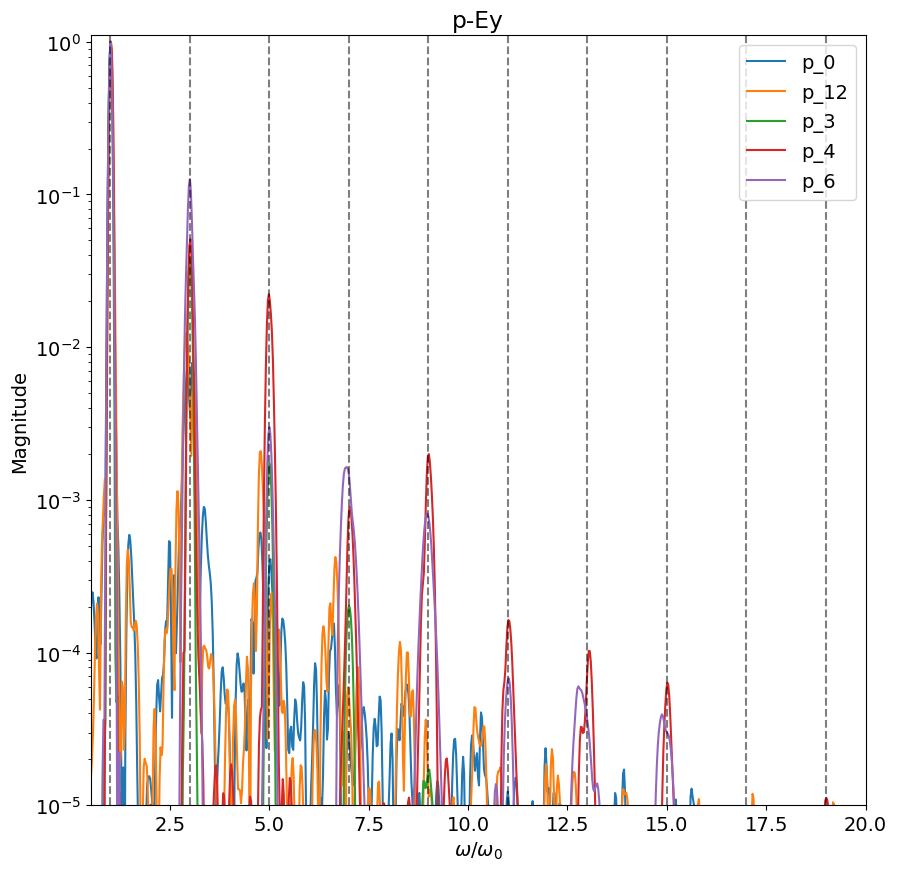

In [27]:
datas = ['p_0', 'p_12', 'p_3', 'p_4', 'p_6']
lines = np.arange(1, 21, 2)
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
for data in datas:
    ax.plot(data_dict[data][0]/omega, (data_dict[data][2])**2, label=data)
    ax.set_yscale("log")

for line in lines:
    ax.axvline(line, color="black", linestyle="--", alpha=0.5)
ax.legend()
ax.set_xlim(0.5, 20)
ax.set_ylim(1e-5, 1.1)
plt.xlabel(r"$\omega/\omega_0$")
plt.ylabel(r"Magnitude")
ax.set_title("p-Ey")
save_fig(ax, "p-Ey.png")

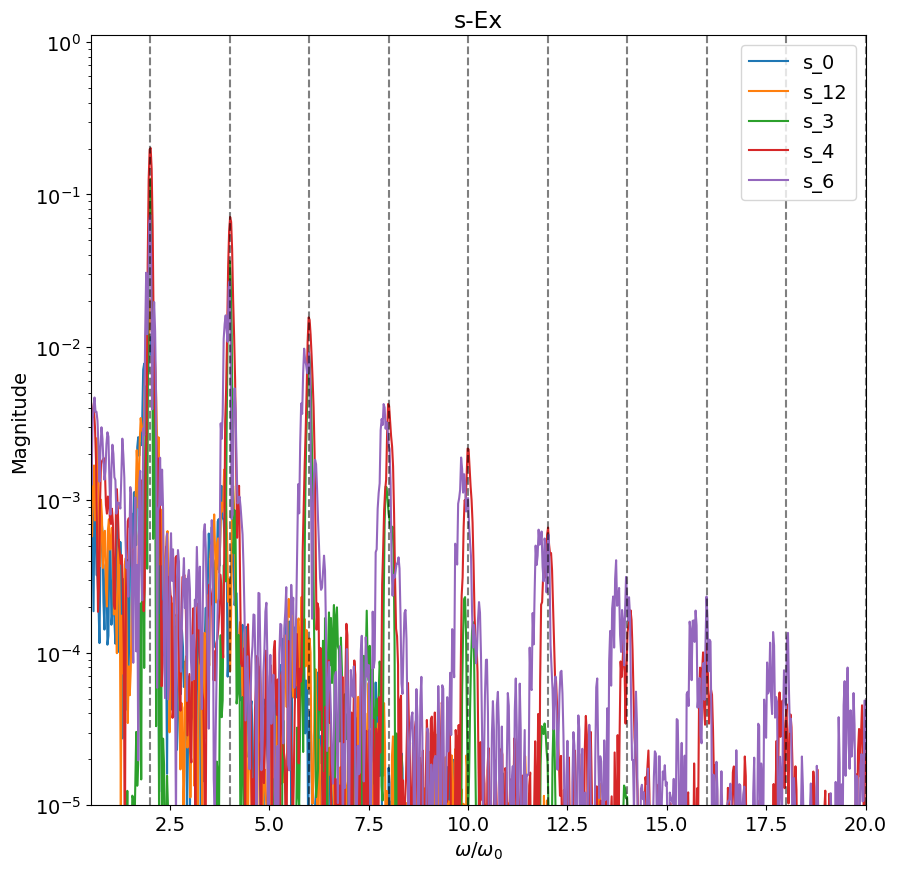

In [20]:
datas = ['s_0', 's_12', 's_3', 's_4', 's_6']
lines = np.arange(0, 21, 2)
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
for data in datas:
    ax.plot(data_dict[data][0]/omega, (data_dict[data][1])**2, label=data)
    ax.set_yscale("log")

for line in lines:
    ax.axvline(line, color="black", linestyle="--", alpha=0.5)
ax.legend()
ax.set_xlim(0.5, 20)
ax.set_ylim(1e-5, 1.1)
plt.xlabel(r"$\omega/\omega_0$")
plt.ylabel(r"Magnitude")
ax.set_title("s-Ex")
save_fig(ax, "s-Ex.png")

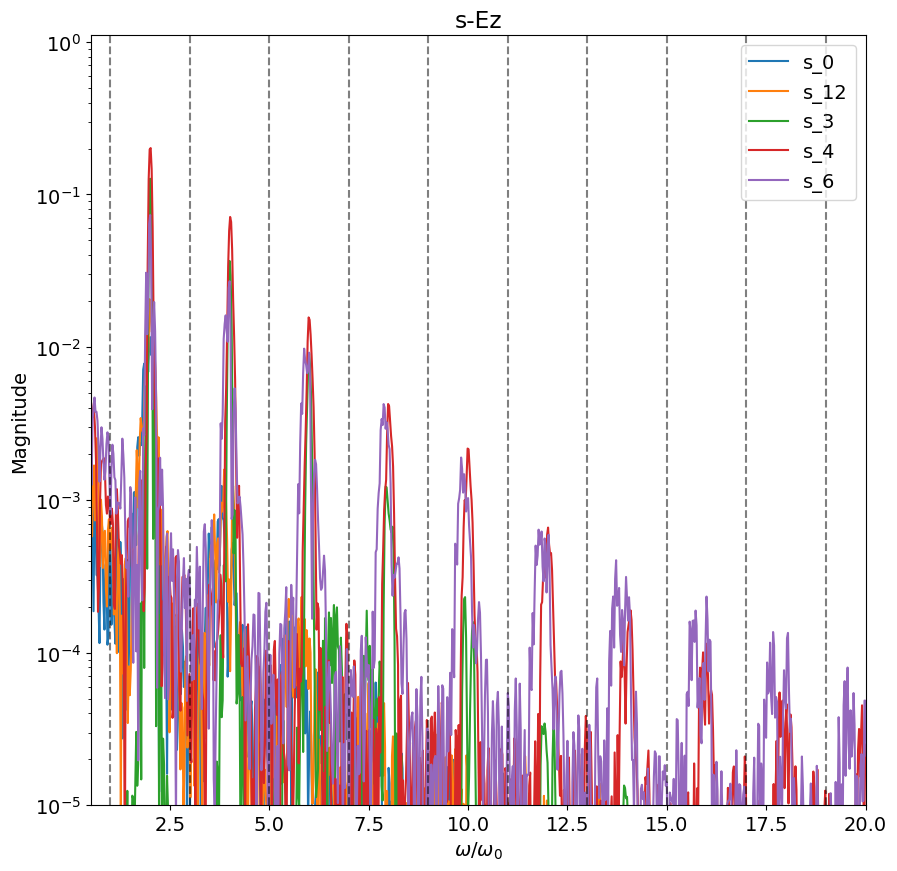

In [28]:
datas = ['s_0', 's_12', 's_3', 's_4', 's_6']
lines = np.arange(1, 21, 2)
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
for data in datas:
    ax.plot(data_dict[data][0]/omega, (data_dict[data][1])**2, label=data)
    ax.set_yscale("log")

for line in lines:
    ax.axvline(line, color="black", linestyle="--", alpha=0.5)
ax.legend()
ax.set_xlim(0.5, 20)
ax.set_ylim(1e-5, 1.1)
plt.xlabel(r"$\omega/\omega_0$")
plt.ylabel(r"Magnitude")
ax.set_title("s-Ez")
save_fig(ax, "s-Ez.png")

## Single Angle Together

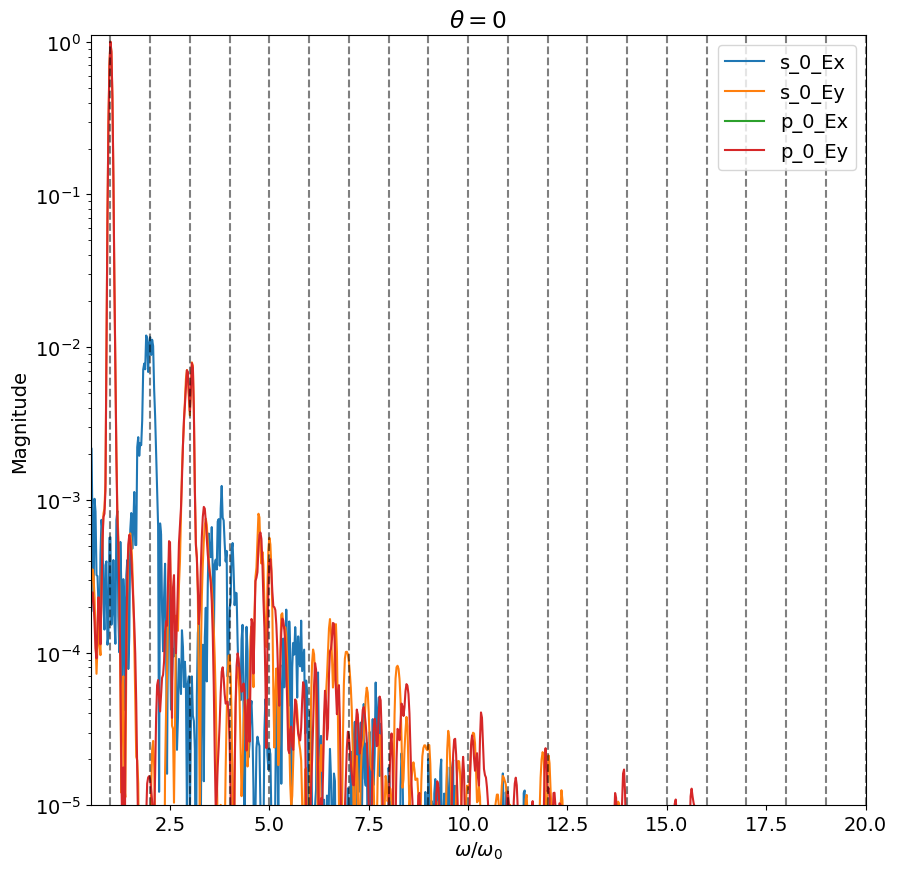

In [22]:
datas = ['s_0', "p_0"]
lines = np.arange(0, 21, 1)
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
for data in datas:
    ax.plot(data_dict[data][0]/omega, (data_dict[data][1])**2, label=f"{data}_Ex")
    ax.plot(data_dict[data][0]/omega, (data_dict[data][2])**2, label=f"{data}_Ey")
    ax.set_yscale("log")
plt.xlabel(r"$\omega/\omega_0$")
plt.ylabel(r"Magnitude")
for line in lines:
    ax.axvline(line, color="black", linestyle="--", alpha=0.5)
ax.legend()
ax.set_xlim(0.5, 20)
ax.set_ylim(1e-5, 1.1)
ax.set_title(r"$\theta=0$")
save_fig(ax, "s-p-0.png")

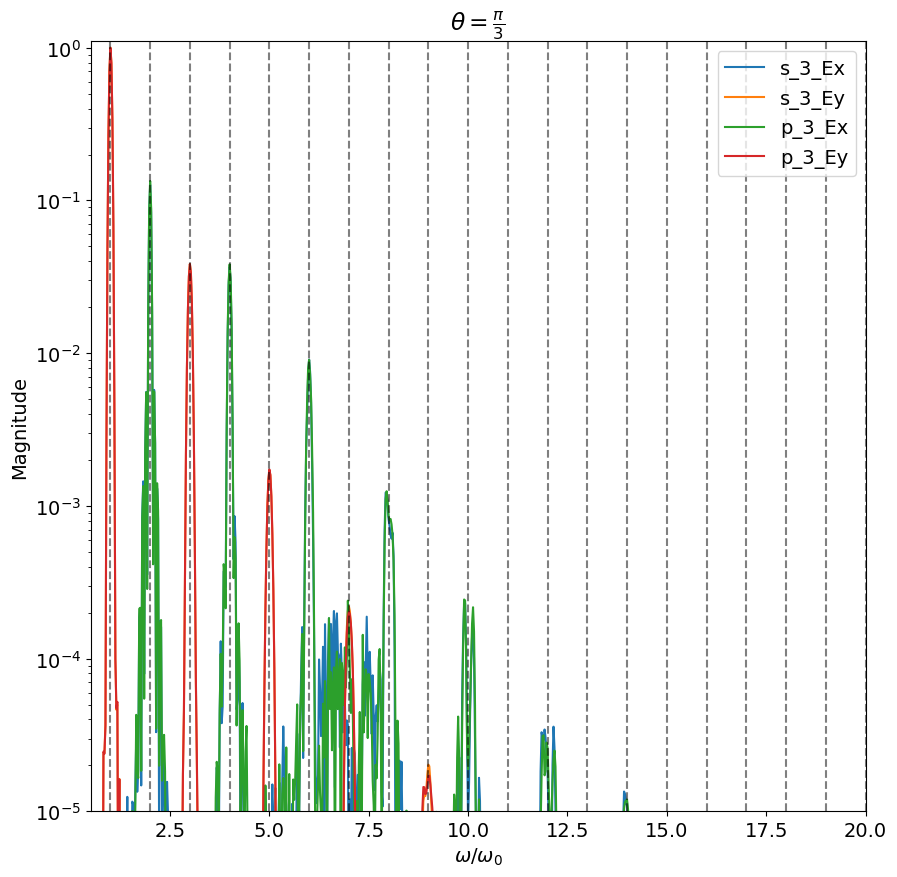

In [23]:
datas = ['s_3', "p_3"]
lines = np.arange(0, 21, 1)
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
for data in datas:
    ax.plot(data_dict[data][0]/omega, (data_dict[data][1])**2, label=f"{data}_Ex")
    ax.plot(data_dict[data][0]/omega, (data_dict[data][2])**2, label=f"{data}_Ey")
    ax.set_yscale("log")
plt.xlabel(r"$\omega/\omega_0$")
plt.ylabel(r"Magnitude")
for line in lines:
    ax.axvline(line, color="black", linestyle="--", alpha=0.5)
ax.legend()
ax.set_xlim(0.5, 20)
ax.set_ylim(1e-5, 1.1)
ax.set_title(r"$\theta=\frac{\pi}{3}$")
save_fig(ax, "s-p-3.png")

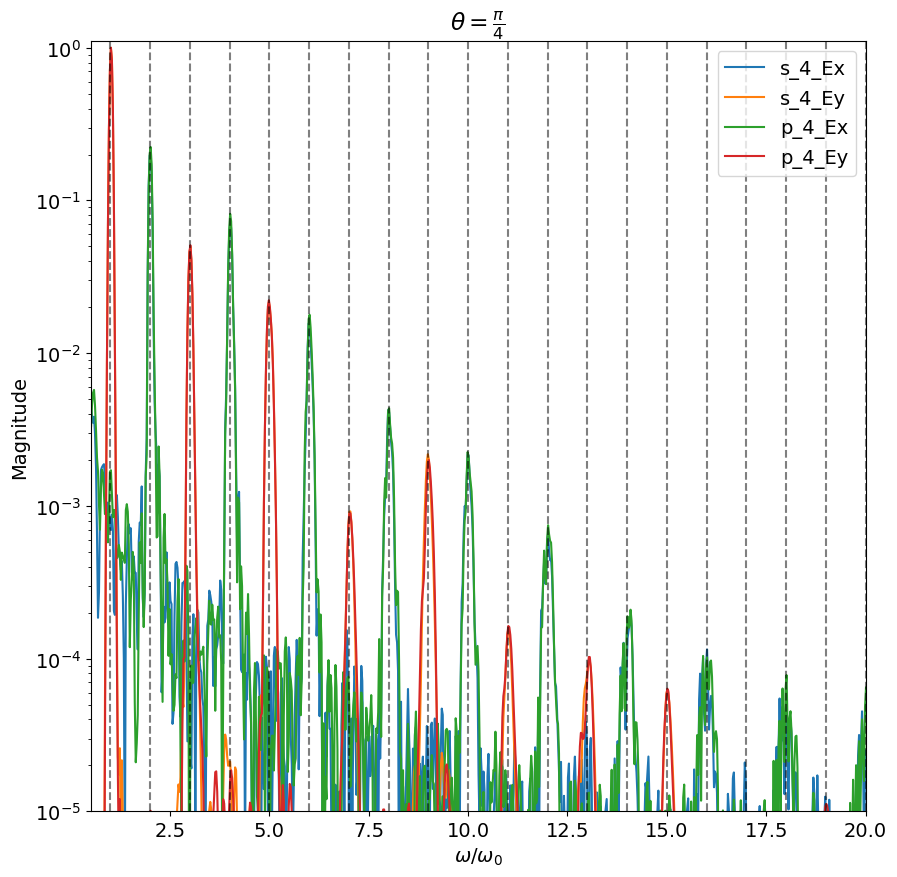

In [24]:
datas = ['s_4', "p_4"]
lines = np.arange(0, 21, 1)
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
for data in datas:
    ax.plot(data_dict[data][0]/omega, (data_dict[data][1])**2, label=f"{data}_Ex")
    ax.plot(data_dict[data][0]/omega, (data_dict[data][2])**2, label=f"{data}_Ey")
    ax.set_yscale("log")
plt.xlabel(r"$\omega/\omega_0$")
plt.ylabel(r"Magnitude")
for line in lines:
    ax.axvline(line, color="black", linestyle="--", alpha=0.5)
ax.legend()
ax.set_xlim(0.5, 20)
ax.set_ylim(1e-5, 1.1)
ax.set_title(r"$\theta=\frac{\pi}{4}$")
save_fig(ax, "s-p-4.png")

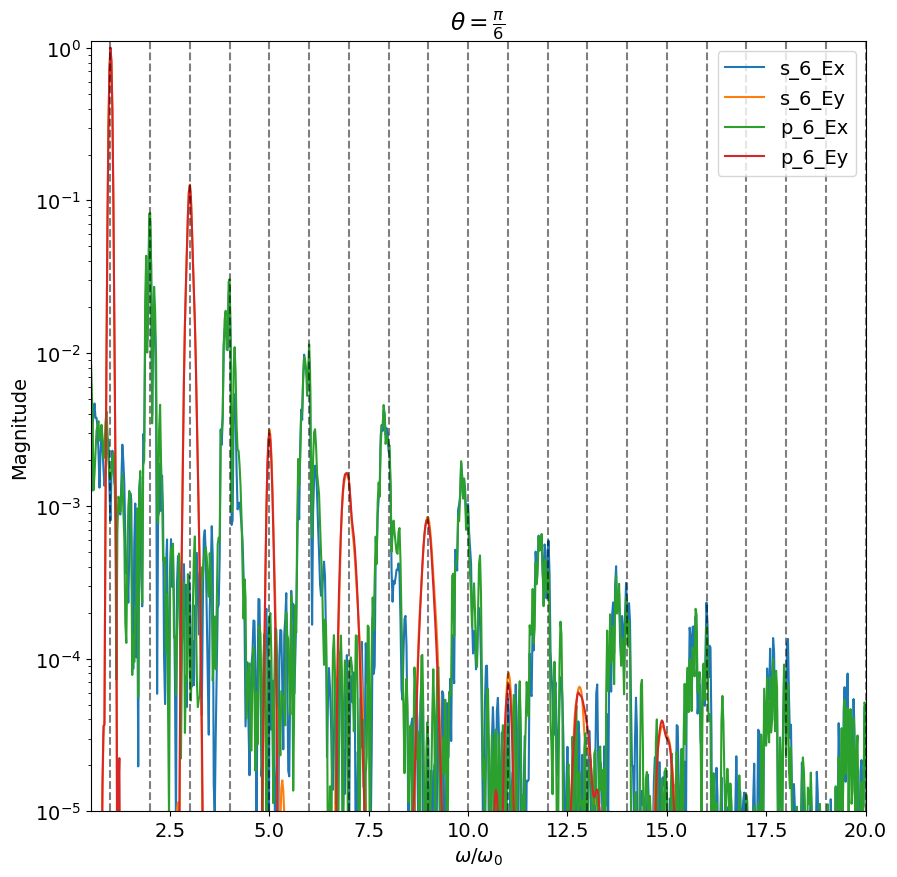

In [25]:
datas = ['s_6', "p_6"]
lines = np.arange(0, 21, 1)
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
for data in datas:
    ax.plot(data_dict[data][0]/omega, (data_dict[data][1])**2, label=f"{data}_Ex")
    ax.plot(data_dict[data][0]/omega, (data_dict[data][2])**2, label=f"{data}_Ey")
    ax.set_yscale("log")
plt.xlabel(r"$\omega/\omega_0$")
plt.ylabel(r"Magnitude")
for line in lines:
    ax.axvline(line, color="black", linestyle="--", alpha=0.5)
ax.legend()
ax.set_xlim(0.5, 20)
ax.set_ylim(1e-5, 1.1)
ax.set_title(r"$\theta=\frac{\pi}{6}$")
save_fig(ax, "s-p-6.png")

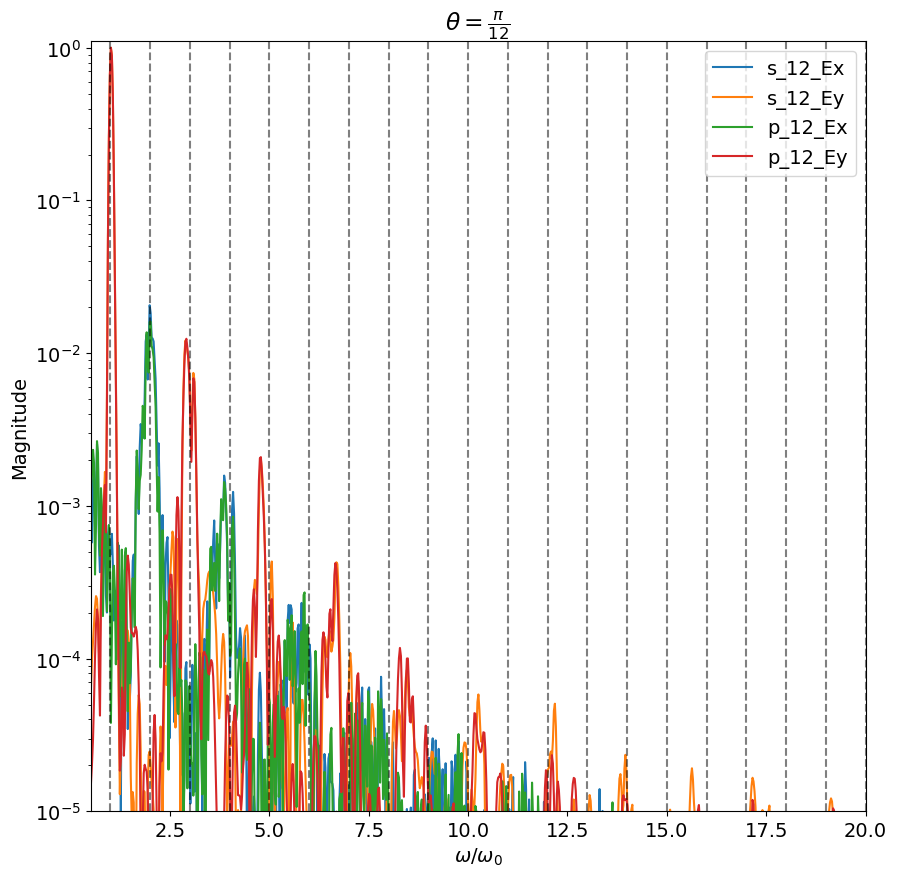

In [26]:
datas = ['s_12', "p_12"]
lines = np.arange(0, 21, 1)
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
for data in datas:
    ax.plot(data_dict[data][0]/omega, (data_dict[data][1])**2, label=f"{data}_Ex")
    ax.plot(data_dict[data][0]/omega, (data_dict[data][2])**2, label=f"{data}_Ey")
    ax.set_yscale("log")
plt.xlabel(r"$\omega/\omega_0$")
plt.ylabel(r"Magnitude")
for line in lines:
    ax.axvline(line, color="black", linestyle="--", alpha=0.5)
ax.legend()
ax.set_xlim(0.5, 20)
ax.set_ylim(1e-5, 1.1)
ax.set_title(r"$\theta=\frac{\pi}{12}$")
save_fig(ax, "s-p-12.png")